### evaluate a pit model by draw prediction visually for a long horizon

MLP-pitmodel-v4


base: 11./evaluate_model_visualdraw

+ visualization of pitagemodel



In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import indycar.model.evaluate_fulltest_fastrun_paper as ev

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


## Load Data

In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

#### evaluate

In [3]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        
        
        
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        

        #axs.set_xlim((80,110))
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        
        if outputfile != '':
            plt.savefig(outputfile + '-%d.pdf'%idx)
        
        # set the x ticks
        #xtickslocs = plt.gca().get_xticks()
        #print(xtickslocs)
        #ticks = [tick for tick in plt.gca().get_xticklabels()]
        #print(ticks)        
        
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 10)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)
        
        
        
        
        plt.show()
        


In [4]:
import pickle
def savedata(datafile,dfs):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = dfs
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
        
def loaddata(datafile):
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        return dfout        

In [16]:
def long_predict_bymloutput(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

In [5]:
# construct long prediction result


def plot_forecasts_h(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        #ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()

    
    
def plot_forecasts(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        #ax = plt.subplot(figcnt, 1, idx+1)
        ax = plt.subplot(1, figcnt, idx+1)
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+80,xl+110))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-5,+23))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '-%d.pdf'%0)
    
def plot_forecast_singles(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet'],
                    xlim_l=80, xlim_h=110):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    #fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(4,3))
        #ax = plt.subplot(figcnt, 1, idx+1)
        ax = plt.subplot(1, 1, 1)
        
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        #ts_entry.iloc[-plot_length:,0].plot(ax=axs[idx], linewidth=1)  # plot the time series
        ts_entry.iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    #for idx in range(len(forecast_entry)):
    #    forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        #forecast_entry[1].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='b')
        #forecast_entry[2].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='r')
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x+1) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+xlim_l,xl+xlim_h))
        #ax.set_xlim((xl+79,xl+109))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-2,+26))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
        plt.show()
        fig.tight_layout()
        fig.savefig(outputfile + '-%d.pdf'%(idx+1))    

### evaluate

In [6]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}


In [7]:
prediction_length = 2
freq = '1min'

In [8]:
ev._dataset_id = 'indy2013-2018-nocarid'
ev._dataset_id = 'indy2013-2018'
#_test_event = 'Indy500-2019'
ev._test_event = 'Indy500-2018'

ev._task_id = 'rank'  # rank,laptime, the trained model's task
ev._run_ts = ev.COL_RANK   #COL_LAPTIME,COL_RANK
ev._exp_id='rank'  #rank, laptime, laptim2rank, timediff2rank... 

ev._feature_mode = ev.FEATURE_STATUS
ev._context_ratio = 0.

ev.init()

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/evaluate_fulltest_fastrun_paper.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


In [9]:
test_cars = [12]
save_prefix = 'test-' + ev._test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

In [10]:
train_ds, test_ds,_,_ = ev.make_dataset_byevent(events_id[ev._test_event], prediction_length,freq, 
                                     oracle_mode=ev.MODE_ORACLE,
                                     run_ts = ev._run_ts,
                                     test_event = ev._test_event,
                                     test_cars=test_cars,
                                     half_moving_win = 0,
                                     train_ratio = 0.4)


train len:0, test len:188, mae_track:0.0,mae_lap:0.0,


### load model from dfout

In [12]:
def load_dfout(datafile):
    #with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        
        return dfout[0]

In [13]:
### load ml models
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''
outfile=f'shortterm-dfout-mlmodels-indy500-tr2013_2017-te2018_2019-end{include_str}-rerank-t{_trim}.pickle'
preddf = load_dfout(outfile)

outfile=f'shortterm-dfout-ranknet-indy500-tr2013_2017-te2018_2019-end{include_str}-normal-t{_trim}.pickle'
oracle_df = load_dfout(outfile)

#ranknet
outfile='../result/22.PaperFinal/shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
#outfile='shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
data = load_dfout(outfile)
ranknet_df, acc, ret = data

In [14]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]

In [15]:
dfin.head(2)

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
7,12.0,9.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0
40,12.0,10.0,2.0,2.0,12.0,0.0,0.0,10.0,1.0


In [17]:
len(dfin)

188

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)


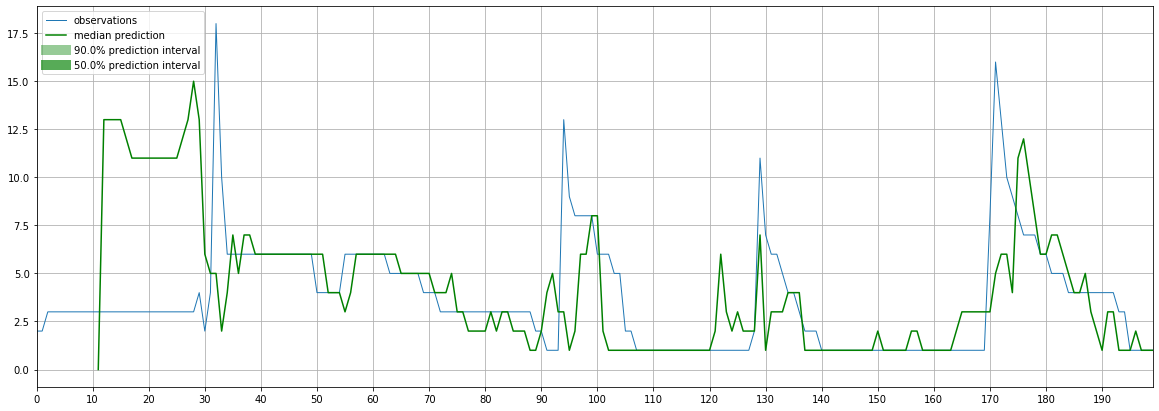

In [18]:
df = preddf['2018']['rf']
dfin = df[df['carno']==test_cars[0]]
predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
target, tss = long_predict_bymloutput('', dfin)
plot_prob_forecasts_ex([tss],[target],'')

In [19]:
tss_template = tss

### multi draw

In [39]:
#xgb
df = preddf['2018']['xgb']
dfin_xgb = df[df['carno']==test_cars[0]]
target_xgb, tss_xgb = long_predict_bymloutput('xgb-rank', dfin_xgb)

#xgb
df = preddf['2018']['svr']
dfin_svr = df[df['carno']==test_cars[0]]
target_svr, tss_svr = long_predict_bymloutput('svr-rank', dfin_svr)

#rf
df = preddf['2018']['rf']
dfin_rf = df[df['carno']==test_cars[0]]
target_rf, tss_rf = long_predict_bymloutput('rf-rank', dfin_rf)


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)


xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)
xlim: (25771680.0, 25771879.0)
ylim: (-10.5489670753479, 23.795226764678954)


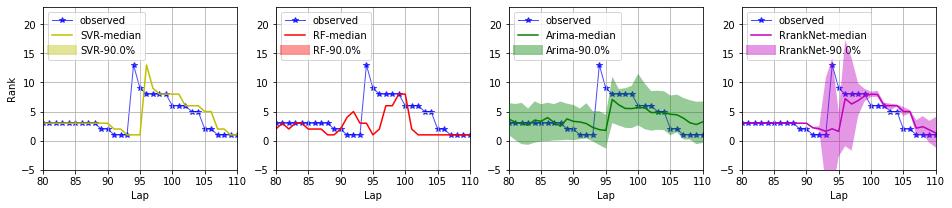

In [42]:
plot_forecasts(tss_arima, [target_svr, target_rf,target_arima, target_oracle],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

In [52]:
savedata('Fig3-RankNet-Oracle.pickle',[tss_arima, target_svr, target_rf,target_arima, target_oracle])

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)
xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


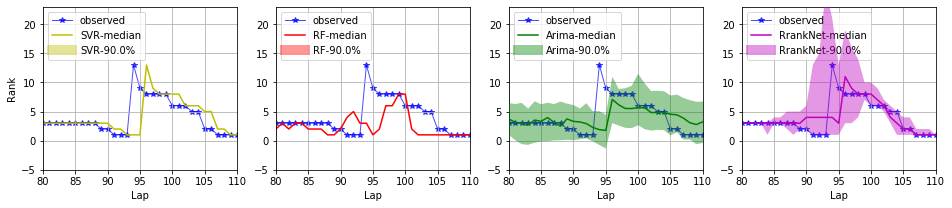

In [44]:
plot_forecasts(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

In [53]:
savedata('Fig3-RankNet-MLP.pickle',[tss_arima, target_svr, target_rf,target_arima, target_ranknet_1run])

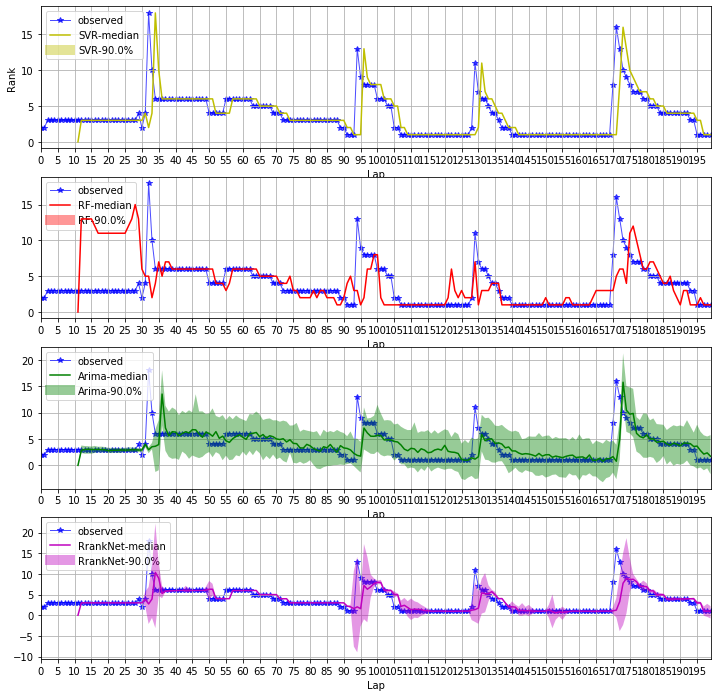

In [50]:
plot_forecasts_h(tss_arima, [target_svr, target_rf,target_arima, target_oracle],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

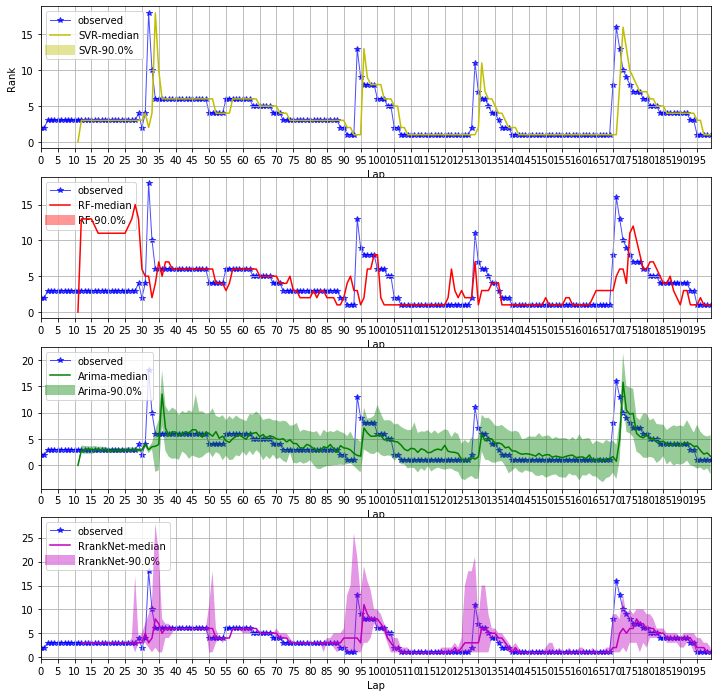

In [51]:
plot_forecasts_h(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

### test ranknet

In [ ]:
#ranknet
outfile='../result/22.PaperFinal/shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-alldata.pickle'
data = load_dfout(outfile)
ranknet_df, acc, ret = data



In [26]:
ret['pitmodel-RANK-2018-inlap-nopitage'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [45]:
ret['pitmodel-RANK-2018-inlap-nopitage'][0][1][test_cars[0]]

array([[nan, nan, nan, ...,  1.,  2.,  1.],
       [nan, nan, nan, ...,  1.,  2.,  0.],
       [nan, nan, nan, ...,  1.,  0.,  2.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  3.,  1.,  0.],
       [nan, nan, nan, ...,  2.,  0.,  0.]])

In [46]:
ret['pitmodel-RANK-2018-inlap-nopitage'][0][2][test_cars[0]]

array([ 1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  3.,  1.,  3., 17.,  9.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,  3.,
        3.,  3.,  3.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  4.,
        4.,  4.,  4.,  4.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
        0.,  0.,  0., 12.,  8.,  7.,  7.,  7.,  7.,  5.,  5.,  5.,  4.,
        4.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 10.,
        6.,  5.,  5.,  4.,  3.,  3.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  7., 15., 12.,  9.,  8.,  7.,  6.,  6.,  6.,  5.,  5

In [37]:
dfs = []
for id in range(100):
    df = ret['pitmodel-RANK-2018-inlap-nopitage'][id][0]
    df = df[df['carno']==test_cars[0]]
    dfs.append(df)
    
dfin_ranknet = pd.concat(dfs)

In [38]:
dfin_ranknet

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
7,12,10,2.0,2.0,0.0,0,2.0,0.0,0
40,12,11,2.0,2.0,0.0,0,2.0,0.0,0
73,12,12,2.0,2.0,0.0,0,2.0,0.0,0
106,12,13,2.0,2.0,0.0,0,2.0,0.0,0
139,12,14,2.0,2.0,0.0,0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...
5236,12,193,2.0,0.0,-2.0,-1,1.0,-1.0,-1
5259,12,194,2.0,0.0,-2.0,-1,2.0,0.0,0
5282,12,195,0.0,0.0,0.0,0,0.0,0.0,0
5305,12,196,0.0,0.0,0.0,0,0.0,0.0,0


In [39]:
target_ranknet, tss_ranknet = long_predict_bymloutput('ranknet-rank', dfin_ranknet)

tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2


In [51]:
#rf
df = preddf['2018']['rf']
dfin_rf = df[df['carno']==test_cars[0]]
target_rf, tss_rf = long_predict_bymloutput('rf-rank', dfin_rf)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)


xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


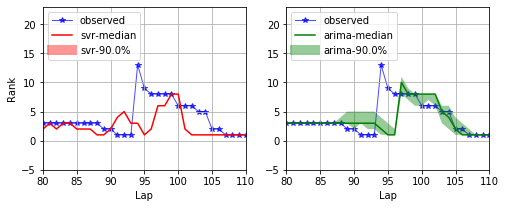

In [42]:
plot_forecasts(tss_rf, [target_rf, target_ranknet], 'ranknet-rf-rank-forecast')

In [58]:
samples = ret['pitmodel-RANK-2018-inlap-nopitage'][0][1][test_cars[0]]
tss  = ret['pitmodel-RANK-2018-inlap-nopitage'][0][2][test_cars[0]]

target_ranknet_1run, tss_ranknet_1run = long_predict_bysamples('ranknet-rank', samples, tss)


tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
target samples shape: (100, 189)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


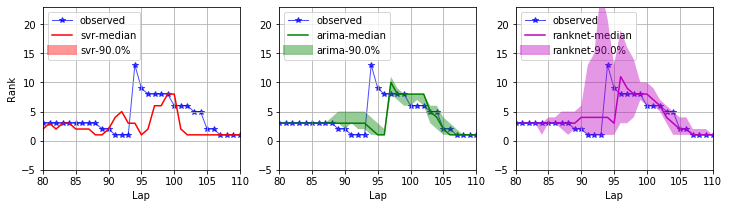

In [59]:
plot_forecasts(tss_rf, [target_rf, target_ranknet,target_ranknet_1run], 'ranknet-rf-rank-forecast')

### draw singles

In [29]:
#savedata('Fig3-RankNet-Oracle.pickle',[tss_arima, target_svr, target_rf,target_arima, target_oracle])
tss_arima, target_svr, target_rf,target_arima, target_oracle = loaddata('Fig3-RankNet-Oracle.pickle')

In [30]:
tss_arima, target_svr, target_rf,target_arima, target_ranknet_1run = loaddata('Fig3-RankNet-MLP.pickle')

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)
xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)
xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


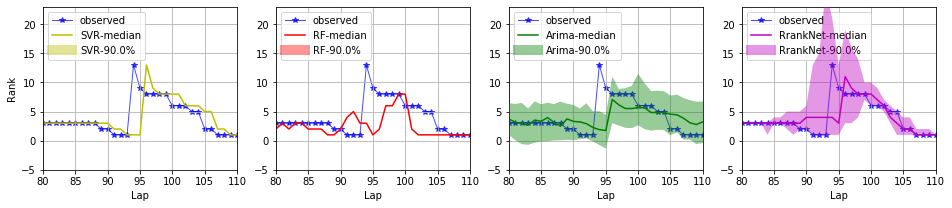

In [31]:
plot_forecasts(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


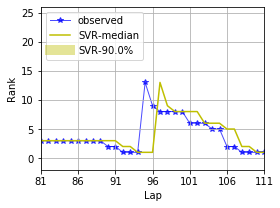

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


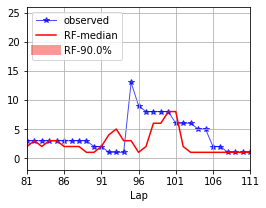

xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)


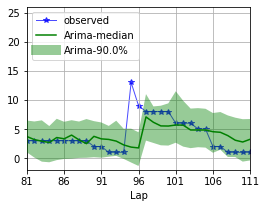

xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


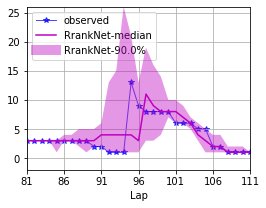

In [32]:
plot_forecast_singles(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'])

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


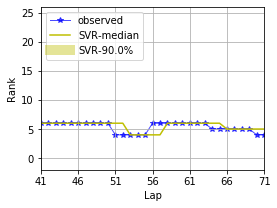

xlim: (25771680.0, 25771879.0)
ylim: (-0.9, 18.9)


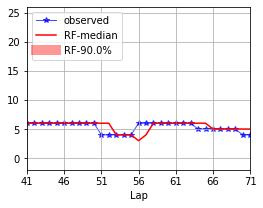

xlim: (25771680.0, 25771879.0)
ylim: (-4.40654432624024, 22.474559847491765)


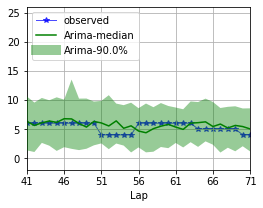

xlim: (25771680.0, 25771879.0)
ylim: (-0.3500000000000001, 29.35)


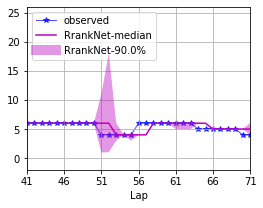

In [39]:
plot_forecast_singles(tss_arima, [target_svr, target_rf,target_arima, target_ranknet_1run],
               'ranknet-rf-rank-forecast-pit50',
                   colors = ['y','r','g','m'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet'],
              xlim_l=40,xlim_h=70)

## PitModel dataset

In [165]:
from gluonts.model.forecast import SampleForecast
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, sample_cnt=100):
        """
        test_ds as testset, the unsclaed input
        """
        
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

        #build a new forecasts object
        nf = []
        for idx, rec in enumerate(test_ds):
            
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                onecast[i] = self.predict(feat[0], feat[[1],feat[2]])
        
            nfc = SampleForecast(samples = onecast, 
                                 freq='1min', start_date=start)
            nf.append(nfc)

        return nf
    
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        the probability of pitstop at plen laps
        long-prediction for a single car, 
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    def forecast_onecar_lap2nextpit(self, test_ds, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen))
        
        for idx, rec in enumerate(test_ds):
                
            target = rec[0]
            feat = rec[1:]
            
            tss[idx] = target
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                onecast[i, idx] = nextpit
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss    

In [87]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
#datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps.pickle'
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps-includeend.pickle'

df_train, df_test, events, testevent, _data = loaddata(datafile)
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

In [131]:
prob, pit, fc, target, model = {}, {},{}, {}, {}


In [132]:
def get_predprob_by_model(modelfile, test_ds):
    pitmodel = PitModel()
    pitmodel.load_model(modelfile)
    forecast,targets = pitmodel.forecast_onecar(test_ds)

    #fill template
    tss = tss_template.copy()
    for idx in range(len(tss)):
        if idx < len(targets):
            tss.iloc[idx, 0] = targets[idx]
        else:
            tss.iloc[idx, 0] = 0

    #pred
    pred = np.mean(forecast.samples, axis=0)

    #pitstops
    pitidx = np.where(targets==1)
    pits = targets[pitidx]

    x = pitidx[0].reshape(-1)
    y = np.zeros_like(x)
    y = pred[x]
    pitstop = np.array([x+1,y])

    
    x = np.arange(len(pred)) + 1
    y = pred
    probability = np.array([x,y])
    
    return probability, pitstop, forecast, targets, pitmodel

In [133]:
allruns = ['sel','all','noshort']
for rid in allruns:
    prob[rid], pit[rid],fc[rid],target[rid],model[rid] = get_predprob_by_model(f'pitmodel-m65-mlp-d{rid}-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle', test_ds)
    

init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
init model:pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle
init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


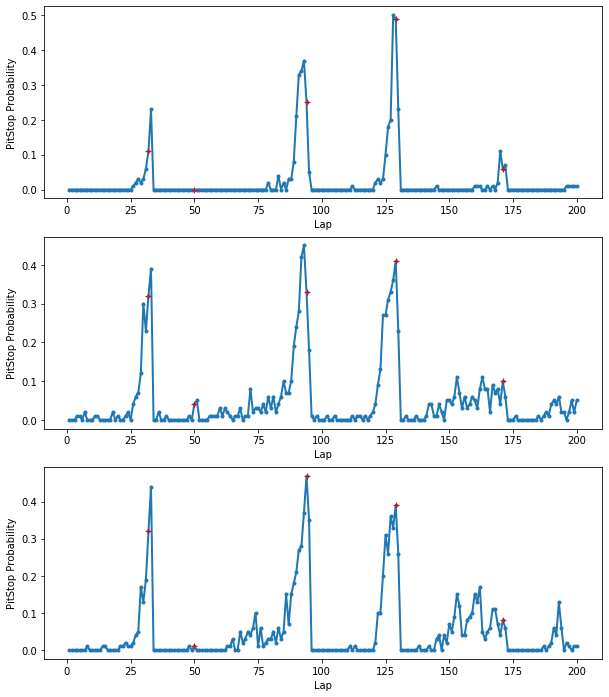

In [134]:
figcnt = len(allruns)
fig, axs = plt.subplots(figcnt, 1, figsize=(10, 4*figcnt))
for idx, rid in enumerate(allruns):
    axs[idx].plot(prob[rid][0,:],prob[rid][1,:],'.-',label='PitStop', linewidth=2)
    axs[idx].plot(pit[rid][0,:],pit[rid][1,:] ,'+',color='r', label='PitStopX', linewidth=2)
    axs[idx].set_ylabel('PitStop Probability')
    axs[idx].set_xlabel('Lap')

## paper figure

In [135]:
# load stagedata and draw status
stagedata = loaddata(f'stagedata-{dbid}.pickle')

In [136]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2018']
df12 = rankdata[rankdata['car_number']==12]
data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
pitstop = df12[['lap_status']].values
caution = df12[['track_status']].values
pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
caution = np.array([1 if x=='Y' else 0 for x in caution])
pitidx = np.where(pitstop == 1)
pits = data[pitidx]
yidx = np.where(caution == 1)
cautions = data[yidx]



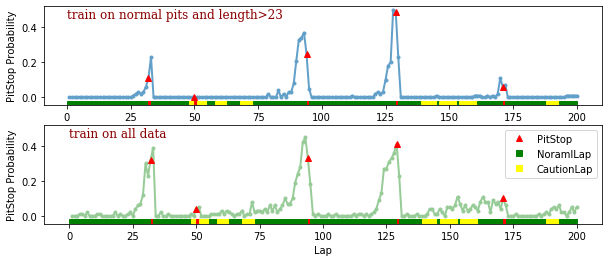

In [161]:
#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

light_blue = '#62a0ca'
light_green = '#97cb97'
light_magenta = '#e597e5'

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

def add_status(axs,y=-0.04, height=0.02):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

lw=2
        
fig, axs = plt.subplots(2, 1, figsize=(10, 4))

rid = 'sel'
axs[0].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_blue ,label='', linewidth=lw)
axs[0].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[0].set_ylabel('PitStop Probability')
axs[0].set_xlabel('Lap')
add_status(axs[0])
axs[0].set_ylim((-0.045,0.52))
axs[0].text(0,0.45, 'train on normal pits and length>23',fontdict=font)

rid = 'all'
axs[1].plot(prob[rid][0,:],prob[rid][1,:],'.-',color=light_green,label='', linewidth=lw)
axs[1].plot(pit[rid][0,:],pit[rid][1,:],'^',color='r', label='PitStop', linewidth=lw)
axs[1].set_ylabel('PitStop Probability')
axs[1].set_xlabel('Lap')
add_status(axs[1])
axs[1].set_ylim((-0.045,0.52))
axs[1].text(0,0.45, 'train on all data',fontdict=font)


axs[1].plot([0],[-10],'s',color=green, label='NoramlLap', linewidth=lw)
axs[1].plot([0],[-10],'s',color=yellow, label='CautionLap', linewidth=lw)
plt.legend(prop={'size': 10})
plt.savefig('probility_output_pitmodel.pdf')

## raw long prediction

In [166]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds)

init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


In [175]:
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0

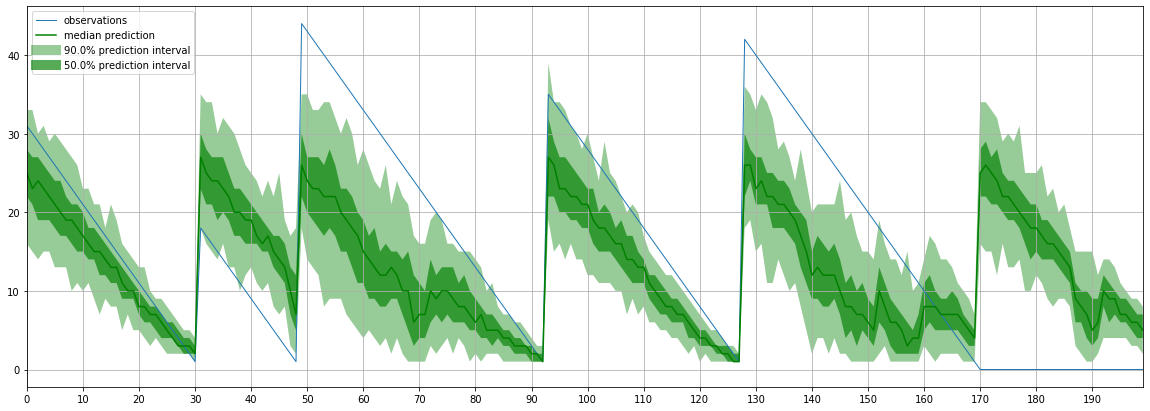

In [176]:
plot_prob_forecasts_ex([tss],[forecast],'')

In [174]:
targets[:-10]

array([ 31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,
        20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,
         9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,   1.,  18.,  17.,
        16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,   6.,
         5.,   4.,   3.,   2.,   1.,  44.,  43.,  42.,  41.,  40.,  39.,
        38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,  28.,
        27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,  18.,  17.,
        16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,   6.,
         5.,   4.,   3.,   2.,   1.,  35.,  34.,  33.,  32.,  31.,  30.,
        29.,  28.,  27.,  26.,  25.,  24.,  23.,  22.,  21.,  20.,  19.,
        18.,  17.,  16.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,
         7.,   6.,   5.,   4.,   3.,   2.,   1.,  42.,  41.,  40.,  39.,
        38.,  37.,  36.,  35.,  34.,  33.,  32.,  31.,  30.,  29.,  28.,
        27.,  26.,  25.,  24.,  23.,  22.,  21.,  2

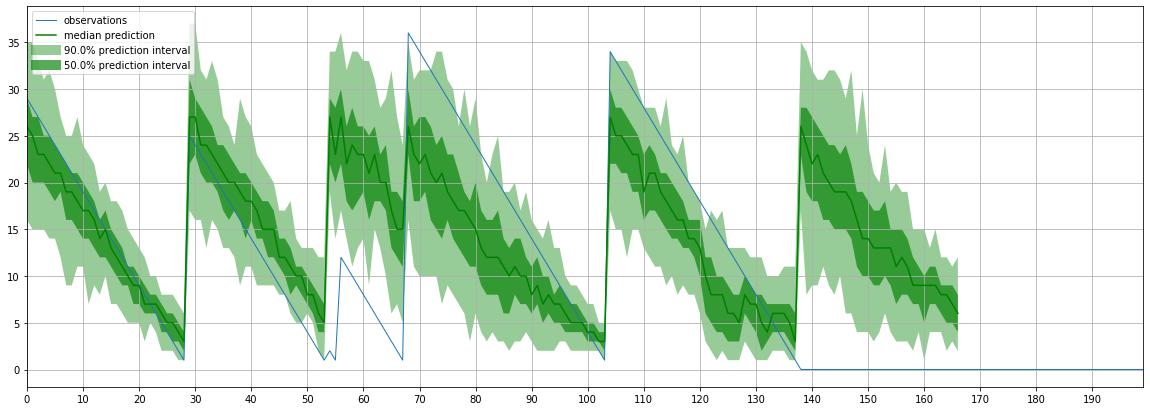

In [178]:
# check car12 in indy500-2017
test_car12 = df_train[(df_train['carno']==12) & (df_train['eid']==4)]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
forecast,targets = pitmodel.forecast_onecar_lap2nextpit(test_ds)
#fill template
targets[np.where(targets==999)] = 0
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0
plot_prob_forecasts_ex([tss],[forecast],'')        

In [180]:
test_car12[(test_car12['lap']>50) & (test_car12['lap']<60)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
24516,3.0,0.0,22.0,1.0,12,4,51,25.0,0.0
24517,2.0,1.0,23.0,1.0,12,4,52,25.0,1.0
24518,1.0,2.0,24.0,1.0,12,4,53,25.0,2.0
24519,2.0,0.0,0.0,1.0,12,4,54,2.0,0.0
24520,1.0,1.0,1.0,1.0,12,4,55,2.0,1.0
24521,12.0,0.0,0.0,1.0,12,4,56,12.0,0.0
24522,11.0,1.0,1.0,1.0,12,4,57,12.0,1.0
24523,10.0,2.0,2.0,1.0,12,4,58,12.0,2.0
24524,9.0,2.0,3.0,1.0,12,4,59,12.0,0.0


## test

In [101]:
prob['noshort'][0,:]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [78]:
pitmodel = PitModel()
#pitmodel.load_model('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
#pitmodel.load_model('pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
pitmodel.load_model('pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle')
test_car12 = df_test[df_test['carno']==12]
test_ds = test_car12[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

forecast,targets = pitmodel.forecast_onecar(test_ds)



init model:pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle


In [79]:
pitidx = np.where(targets==1)
pits = targets[pitidx]

In [80]:
#fill template
tss = tss_template.copy()
for idx in range(len(tss)):
    if idx < len(targets):
        tss.iloc[idx, 0] = targets[idx]
    else:
        tss.iloc[idx, 0] = 0


In [81]:
tss.iloc[31,0]

1.0

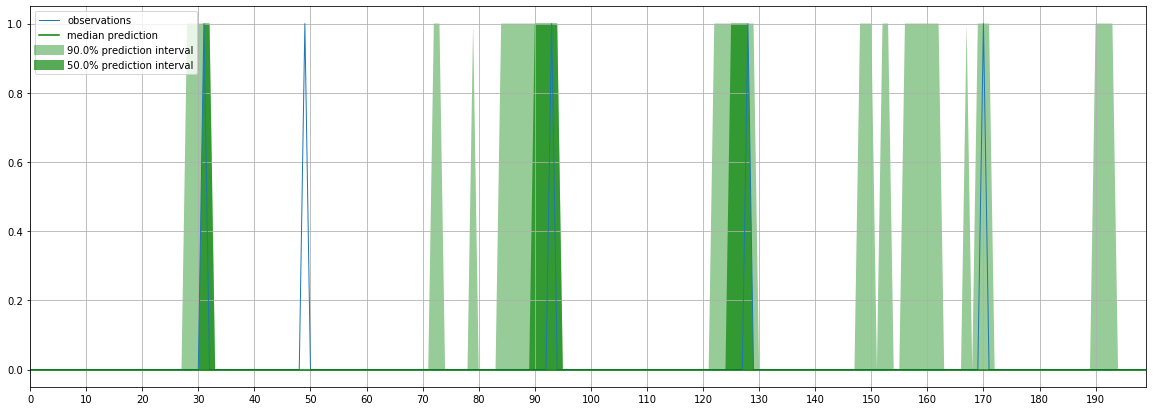

In [82]:
plot_prob_forecasts_ex([tss],[forecast],'')

In [83]:
pred = np.mean(forecast.samples, axis=0)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.03, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.02, 0.01, 0.04, 0.04, 0.15, 0.23, 0.22, 0.3 , 0.32,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.02, 0.03, 0.03, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.01,
       0.02, 0.01, 0.03, 0.03, 0.05, 0.05, 0.1 , 0.11, 0.02, 0.05, 0.05,
       0.01, 0.01, 0.1 , 0.05, 0.01, 0.01, 0.04, 0.06, 0.12, 0.14, 0.09,
       0.2 , 0.25, 0.26, 0.27, 0.3 , 0.29, 0.33, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.03, 0.01, 0.04, 0.03,
       0.04, 0.17, 0.14, 0.24, 0.38, 0.33, 0.41, 0.47, 0.2 , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.02,
       0.  , 0.04, 0.01, 0.01, 0.03, 0.06, 0.1 , 0.

Text(0.5, 0, 'Lap')

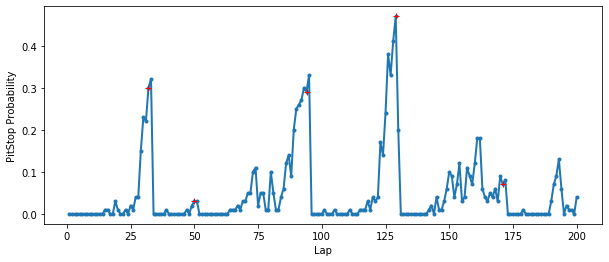

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
#axs.plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
#axs.plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
#axs.plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)
x = np.arange(len(pred)) + 1
axs.plot(x, pred,'.-',label='PitStop', linewidth=2)

x = pitidx[0].reshape(-1)
y = np.zeros_like(x)
y = pred[x]
#axs.scatter(x,y,color='r')
#,'+',color='r', label='PitStopX')
axs.plot(x+1,y,'+',color='r', label='PitStopX', linewidth=2)
axs.set_ylabel('PitStop Probability')
axs.set_xlabel('Lap')

In [78]:
x.shape

(5,)

In [80]:
y.shape

(5,)

In [69]:
pitidx[0]

array([ 31,  49,  93, 128, 170])

In [103]:
test_car12[(test_car12['lap']>45) & (test_car12['lap']<53)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1227,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1228,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1229,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1230,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1231,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1232,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1233,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0


In [37]:
pred[45:55]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
pred.shape

(202,)

In [64]:
test_ds

array([[31.,  0.,  1.,  0.],
       [30.,  0.,  2.,  0.],
       [29.,  0.,  3.,  0.],
       [28.,  0.,  4.,  0.],
       [27.,  0.,  5.,  0.],
       [26.,  0.,  6.,  0.],
       [25.,  0.,  7.,  0.],
       [24.,  0.,  8.,  0.],
       [23.,  0.,  9.,  0.],
       [22.,  0., 10.,  0.],
       [21.,  0., 11.,  0.],
       [20.,  0., 12.,  0.],
       [19.,  0., 13.,  0.],
       [18.,  0., 14.,  0.],
       [17.,  0., 15.,  0.],
       [16.,  0., 16.,  0.],
       [15.,  0., 17.,  0.],
       [14.,  0., 18.,  0.],
       [13.,  0., 19.,  0.],
       [12.,  0., 20.,  0.],
       [11.,  0., 21.,  0.],
       [10.,  0., 22.,  0.],
       [ 9.,  0., 23.,  0.],
       [ 8.,  0., 24.,  0.],
       [ 7.,  0., 25.,  0.],
       [ 6.,  0., 26.,  0.],
       [ 5.,  0., 27.,  0.],
       [ 4.,  0., 28.,  0.],
       [ 3.,  0., 29.,  0.],
       [ 2.,  0., 30.,  0.],
       [ 1.,  0., 31.,  0.],
       [18.,  0.,  0.,  0.],
       [17.,  0.,  1.,  0.],
       [16.,  0.,  2.,  0.],
       [15.,  

In [107]:
model['sel'].predict(1,16,1)

15.0

In [117]:
def testmodel(rid):
    pitmodel = model[rid]
    samples = np.zeros((1000))
    for i in range(1000):
        samples[i] = pitmodel.predict(1,16,1)

    print('min:', np.min(samples))
    print('<5:', np.sum(samples<=5))
    print('prob(plen=2) = ', np.sum(samples==2)/1000)
    return samples

In [118]:
s = testmodel('sel')

min: 3.0
<5: 4
prob(plen=2) =  0.0


In [119]:
s = testmodel('all')

min: 1.0
<5: 157
prob(plen=2) =  0.025


In [120]:
s = testmodel('noshort')

min: 1.0
<5: 148
prob(plen=2) =  0.017
